# Hate_Speech_and_Offensive_Language

Project mentor: Carlos Aguirre

Yuxiang Wang <ywang594@jh.edu>, Jingxi Liu <jliu238@jh.edu>, Wenkai Luo <wluo14@jh.edu>, Yuetong Liu<yliu390@jh.edu>

https://github.com/YuetongLiu/Hate_Speech_and_Offensive_Language

# Outline and Deliverables

### Uncompleted Deliverables
1. "Would like to complete #2": Unsupervised learning: clustering hate speech to identify major topics, including race, colour, sex (ran out of time).
2. "Would like to complete #3": Improvement: link data with CF users to study who are more likely to use hate speech/offensive language. Integrate the frequency of a user detected for posting hate speech and the user’s interaction with others (ran out of time).


### Completed Deliverables
1. "Must complete #1": Data Pre-processing: pre-process text data including deleting duplicates, removing stop words or punctuation, and convertingtweet content to lowercase. in "Pre-processing" below.
2. "Must complete #2": Feature Extraction: Combine skip-gram, LIWC and LDA methods to extract features. [in Feature extractions](https://github.com/YuetongLiu/Hate_Speech_and_Offensive_Language/blob/main/code/Feature_Extraction%20.ipynb)
3. "Must complete #3": Feature Selection: Use PMI on the training data to quantified the importance of each feature. Set up a threshold to choose themost beneficial features. Most features share similar mutual information, so we switched Logistics Regression with L1 regulization.[in "Classic Methods" below](https://github.com/YuetongLiu/Hate_Speech_and_Offensive_Language/blob/main/code/Logistic_n_SVM.ipynb).
4. "Expect to complete #1": EDA: conduct exploratory data analysis. Moreover, conduct correlation analysis between features.in "Pre-processing" below and [in "Classic Methods" below](https://github.com/YuetongLiu/Hate_Speech_and_Offensive_Language/blob/main/code/Logistic_n_SVM.ipynb)
5. "Expect to complete #2": Prediction: Use the F1 value on the Davidson, T. et al. (2017) as a baseline, accurately classify the text comment into hate speech,offensive language or neither. Otherwise, interpret the model to explain the mis-classification.[in "Classic Methods" below](https://github.com/YuetongLiu/Hate_Speech_and_Offensive_Language/blob/main/code/Logistic_n_SVM.ipynb)
6. "Expect to complete #3": Model Selection: Besides logistic regression model, use MLP + CNN as a comparisons to train data and make model selectionbased on their performance. Use cross validation to find optimal hyper-parameters. in "Deep Learning Methods" below]
7. "Would like to complete #1": Beside improving the precision, choose model based onevaluation metrics. [in "Classic Methods" below](https://github.com/YuetongLiu/Hate_Speech_and_Offensive_Language/blob/main/code/Logistic_n_SVM.ipynb)


### Additional Deliverables
1. We add TFIDF as a new method to extract features in [in Feature extractions](https://github.com/YuetongLiu/Hate_Speech_and_Offensive_Language/blob/main/code/Feature_Extraction%20.ipynb)


In [11]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem.porter import *
import string
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from gensim.models.word2vec import Word2Vec
import warnings
from random import choice
from gensim import corpora, models
from gensim.models import CoherenceModel
import csv
from liwc import LIWC
warnings.filterwarnings("ignore")

# Preliminaries

### What problem were you trying to solve or understand?
Our project is to design a hate speech detector. we try to figure out the two key challenges for automatic hate speech detection on social media. The first is to decide whether a post is a hate speech. The second is to separate hate speech and other offensive languages.



### What are the real-world implications of this data and task?

Although the negative emotion expressions increase for internet’s lack of regulation, it makes the detection and supervision of hate speech possible to achieve by artificial intelligence. A machine learning solution could identify hate speech, and then flag it or remove it for review. At present, solution that relied human annotator is expensive and difficult for widespread use. Platform on the internet are interested in an automatic hate speech censor.

### How is this problem similar to others we’ve seen in lectures, breakouts, and homeworks?

The project is similar to Homework#4 of machine learning course, which is a binary classification problem of text data. We implement TFIDF and a support vector machine to classify the topic of news articles. However, it is different in this project that we analyze tweets here instead of documents and we try many combinations of methods on data extraction. The task in this project is more complex for the small size of each sample and the “less-standard English” on Twitter.


### What makes this problem unique?

The problem is unique for two reason. Firstly, there is no legal definition of hate speech in the U.S. law. But it is generally believed that the speech based on identity characteristics such as race and gender, which deliberately incites violence and prejudice, may constitute hate speech. The labels in data are given by users based on their feelings. And we want to build a classifier that is similar as natural human emotion. Secondly, Twitter data is uniquely messy and hard to preprocess. The problems includes misspelling, slang, colloquialisms,  irregular format, meaningless addition and the like.


### What ethical implications does this problem have?
People possess the right to express ideas and information regulated in the First Amendment. Therefore, labelling normal speech as hate speech incorrectly may break the freedom of speech. On the other hand, hate speech can causes many social problems such as racial inequality and climate of intolerance. Therefore, harmful speech left uncensored may violate the rights of others and do harm to the whole society.

## Dataset(s)

Describe the dataset(s) you used.

### 1.How were they collected?

  The data came from the statistics of users’ hate speech and offensive language in social media.

### 2.Why did you choose them?

  First of all, we are very interested in the topic of hate speech and offensive language detection. Secondly, this topic has good social significance and the results of this study can somehow help improve the network environment.

### 3.How many examples in each?

  24783 samples in total and each sample contains 6 columns including labels.


In [12]:
# Load data and show some examples
df=pd.read_csv("../data/labeled_data.csv")
df.drop(df.columns[[0]], axis=1,inplace=True)
print(df.iloc[:3,:])

   count  hate_speech  offensive_language  neither  class  \
0      3            0                   0        3      2   
1      3            0                   3        0      1   
2      3            0                   3        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  


## Pre-processing

1.What features did you use or choose not to use? Why?

We choose to use column named "tweet" which is directly related to our topic and the column named "class" is our label column.Since our 
goal is to detect hate speech and offensive language through text analysis, we decided not to use other features which are related to the 
count of words. 

2.If you have categorical labels, were your datasets class-balanced?

We do have categorical labels, and they are unbalanced.(Shown below)

3.How did you deal with missing data? What about outliers?

Fortunately, our dataset does not have missing data. Besides, what we are really insterested in are all "string" format data, so we do not consider outliers here. While we do deal with some of the tweets that are problematic. For example, some sentences only contain special punctuations, and some sentences have # before every word.

4.What approach(es) did you use to pre-process your data? Why?

We remove less important part of each tweet:<br>
1 Punctuation <br>
2 Stop words <br>
3 Hashtag <br>
4 Username <br>
5 Http information <br>
6 Digit and excessive whitespaces <br>

Then we also transform all the letters into lower case, and then do stemming and tokenization. In particular, we deal with those special problematic sentences by rewriting regular expression for them.

All of the operations above are in order to retain only important information of tweet and remove irrelevant information. Let each of our data maintains words which are related to distinguishing hate speech and offensive language. Finally, our data would be more accurate in word embedding part, which may help the prediction of our models.

5.Are your features continuous or categorical? How do you treat these features differently?

Our data is text format, so after embedding all the tweets we only have continuous numeric vectors.

In [13]:
# For those same examples above, what do they look like after being pre-processed?
print("label 0",np.sum(df["class"]==0))
print("label 1",np.sum(df["class"]==1))
print("label 2",np.sum(df["class"]==2))

label 0 1430
label 1 19190
label 2 4163


Thus our data is obviously unbalanced.

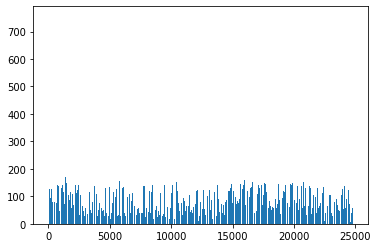

average len before preprocessing 85.43606504458701


In [14]:
# Tweet length before preprocessing
#average len of tweet
tweet = np.array(df["tweet"])
avg=0
num=[]
x=[x for x in range(24783)]
for n in range(tweet.shape[0]):
    avg+=len(tweet[n])
    num.append(len(tweet[n]))
avg=avg/(tweet.shape[0])
plt.bar(x,num)
plt.show()
print("average len before preprocessing",avg)

In [15]:
# Index of tweet only contain format like"#XX #XX" (which would be empty after remove hashtag)
# We need to specially deal with them
special_index=[804,826,846,848,849,923,1016,1122,1909,3398,4818,5711,6098,6279,6332,6668,7168,11951,15859,18062]
# for example
print(df['tweet'][804])

#Yankees


In [16]:
# Also there are two meaningless tweet
print(df['tweet'][4828])
print(df['tweet'][6098])
meaningless_index=[4828,6098]

@TNKidsFoodPorn @Oreo ..............&#128530;
@hoes &#9829;


In [33]:
#copy original text
txt=df.iloc[:,4:6]
tweet=txt.iloc[:,1].copy(deep=True)
stemmer = PorterStemmer()

In [34]:
def preprocess(tweet_,specail_index,meaningless_index):
    #remove stopwords
    stopwords = nltk.corpus.stopwords.words("english")
    other = ["#ff", "ff", "rt"]
    stopwords.extend(other)   
    for i in range(tweet_.shape[0]):
        text=tweet_[i].lower()
        text1=''.join([word+" " for word in text.split() if word not in stopwords])
        tweet_[i]=text1
    
    #remove digit and excessive whitespace
    #remove url mention and hashtag
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    
    for i in range(tweet_.shape[0]):
        text_string=tweet_[i]
        parsed_text = re.sub(space_pattern, ' ', text_string)
        parsed_text = re.sub(giant_url_regex, '', parsed_text)
        parsed_text = re.sub(mention_regex, '', parsed_text) 
        if i not in specail_index:
            parsed_text = re.sub(hashtag_regex, '', parsed_text)
        else:
            parsed_text = re.sub('#','',parsed_text)
        if i in meaningless_index:
            parsed_text ='This is a simple tweet'
        tweet_[i]=parsed_text
    
    #tokenize and stemming
    """Removes punctuation and stems tweets. Returns a list of stemmed tokens."""
    for i in range(tweet_.shape[0]):
        #tweet_stem=tweet_[i]
        #tweet_stem = " ".join(re.split("[^a-zA-Z]*", tweet_stem)).strip()
        #tweet_process = [stemmer.stem(t) for t in tweet_stem.split()]
        #tweet_[i]=tweet_process
        
        tweet_stem=tweet_[i]
        
        remove = str.maketrans('','',string.punctuation) 
        tweet_stem = tweet_stem.translate(remove).strip()

        tweet_process = [stemmer.stem(t) for t in tweet_stem.split()]
        
        tweet_[i]=tweet_process
        
        #tweet_[i] = ' '.join([str(elem) for elem in tweet_process]) 
        
    return tweet_

In [35]:
#results of pre-process
tweet=preprocess(tweet,special_index,meaningless_index)
print(tweet[:5])

0    [woman, complain, clean, hous, amp, man, alway...
1    [boy, dat, coldtyga, dwn, bad, cuffin, dat, ho...
2    [dawg, ever, fuck, bitch, start, cri, confus, ...
3                                 [look, like, tranni]
4    [shit, hear, might, true, might, faker, bitch,...
Name: tweet, dtype: object


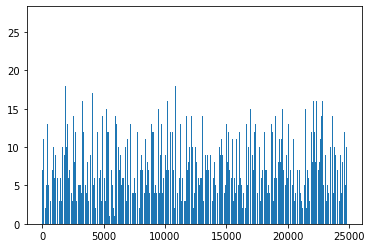

average len after preprocessing 7.689262801113666


In [36]:
# Visualize the distribution of your data before and after pre-processing.
#   You may borrow from how we visualized data in the Lab homeworks.
# Tweet length after preprocessing
avg=0
num=[]
x=[x for x in range(24783)]
for n in range(tweet.shape[0]):
    avg+=len(tweet[n])
    num.append(len(tweet[n]))
avg=avg/(tweet.shape[0])
plt.bar(x,num)
plt.show()
print("average len after preprocessing",avg)

# Models and Evaluation

## Experimental Setup

### How did you evaluate your methods? Why is that a reasonable evaluation metric for the task?
The F1-score is used to evaluate the performance of our model. F1-score is generally used to measure the performance of classification. F1-score can be computed by the following formula: 
\begin{equation*}
    F_1 = 2 \cdot \frac{\textbf{precision} \cdot \textbf{recall}}{\textbf{precision} + \textbf{recall}}
\end{equation*}
where precision and recall can be computed by following:
\begin{align*}
    \textbf{precision} &= \frac{TP}{TP + FP} \\
    \textbf{recall} &= \frac{TP}{TP + FN} \\
\end{align*}
where $TP$, $FP$ and $FN$ are the number of true positive, false positive and false negative respectively. F1-score is suitable for the classification task, especially for the unbalanced dataset, while the total accuracy for the whole classification cannot reflect the performance of model. The dataset we use for our project is an unbalanced dataset, where the hate speech samples are relatively less than the offensive samples and neither samples. Due to the unbalanced property of the dataset, even though we predict all the hate-speech as offensive or neither, it won’t affect the total accuracy too much, however the actual performance of hate speech detection can be really bad. The F1- score also take the false negative part into account which we can see the performance of classifier in the specific class. Thus F1-score is suitable evaluation metric to measure performance of model in this project.


### What did you use for your loss function to train your models? Did you try multiple loss functions? Why or why not?

For the logistic regression with L2 regularization, the loss function is the log loss, 
which can be written in the following form:

\begin{equation*}
L = E_w(Y,x) + E_w(w)    
\end{equation*}
Where 
\begin{align*}
E_w(x) &=   -\sum_{i=1}^N \left[y_i log(\sigma({\bf Wx})) + (1-y_i) log(1 -{\bf Wx}) \right]\\
E_w(w) &=   - \lambda \sum_{c = 1}^C ||\vec{w}_c||_2^2 \\
\sigma({\bf Wx}) &= \frac{1}{1+ e^{-{\bf W^{T} x}}} \\
\end{align*}

For the TextCNN model, the loss function is also cross entropy, which is same as the log loss in logistic regression. We didn’t try different loss functions, because we consider the feature generation is the more important part for the performance of our model. We just used the common loss function in this project.

### How did you split your data into train and test sets? Why?
For the classic method, we just utilize the skit-lean build-in libraries to split our dataset randomly into different portions such as [80% Training data, 20% Testing data] and [90% Training data, 10% Testing data]. 

For the TextCNN, we did try to put more data into training set in order to build a more comprehensive vocabulary dictionary that incorporate as much words as possible, because we will apply word embedding to our sentence in order to represent the sentence mathematically. If size of vocabulary dictionary is too small, the out-of-vocabulary issue will introduce the sparsity into the embedding matrix, which might cause overfitting.

But we have to admit that it might not be a good idea to split our data in this way due to the unbalanced property of the datasets. It might introduce the bias into our model.

### Git repo for feature extractions:
https://github.com/YuetongLiu/Hate_Speech_and_Offensive_Language/blob/main/code/Feature_Extraction%20.ipynb

### Code for loss functions, evaluation metrics or link to Git repo:
https://github.com/YuetongLiu/Hate_Speech_and_Offensive_Language/blob/main/code/Logistic_n_SVM.ipynb

## Baselines 

### What baselines did you compare against? Why are these reasonable?
The baseline mode we choose is the one that provide the dataset in [Automated Hate Speech Detection and the Problem of Offensive Language](http://sdl.soc.cornell.edu/img/publication_pdf/hatespeechdetection.pdf). This model created a pipeline of hate speech detection, which also incorporate most of state-of-art feature generation methods. Also, this baseline model also demonstrates the explicit performance of model in specific hate speech class with the use of F1-score, while other paper might only compare the weighted-average F1-score for all three class. Our classic method using logistic regression and SVM utilize some of the ideas from this baseline while also introduce the embedding feature as our contribution. For the TextCNN model, we aim at exploring the effect of different environment setting to the performance of hate speech classification.

### Did you look at related work to contextualize how others methods or baselines have performed on this dataset/task? If so, how did those methods do?
The difficult of hate-speech detection are the its similarity with offensive language, even some paper consider hate-speech as a subset of offensive language, and its subjectivity, which is also demonstrated in the dataset. [[1]](http://sdl.soc.cornell.edu/img/publication_pdf/hatespeechdetection.pdf).

Hate speech is a interested area where current research can be generally divided into two categories including the classic machine learning method such as logistic method and deep neural network such as TextCNN, LSTM and RNN [[2]]( 2Q2WDCB638D43FE1E1190A9E8DCB8ED30CF459E7560D_unknown_A33959A0DF385E32CF856B03ABAA940EF1C0B61C_4). The classic mostly relies on the feature created from the text file. Several paperd investigate effect of different features, however they just stack the features together and do feature selection to boost the performance. The popular features include PoS, n-gram and so on. The neural network will automatically select the feature by the network. Different neural network including RNN, CNN, LSTM has shown that they have promising future in this application. 

## Classic Methods

### What methods did you choose? Why did you choose them?
Based on the prior work and literature review. Both logistic regression and SVM seem promising methods for this classifying application.In this project, we will be focusing on logistic regression with L2 regularization. A one-versus-rest framework will be applied in thisproject where each classifier will be trained separately for the specific class. During the testing stage, the class with the highest predictedprobability will be labelled for the corresponding sample.

### How did you train these methods, and how did you evaluate them? Why?
We trained this models and evaluated them based on F1_mirco_score. We use micro score because the data is inbalanced, and we are more interested in performance of the minor group(hate speech)

### Which methods were easy/difficult to implement and train? Why?
The model is easy to implement. However, it takes long time to train due to the large dimension of the sparse features.

### For each method, what hyperparameters did you evaluate? How sensitive was your model's performance to different hyperparameter settings?
For logistic Regression, we tuned regularization strength C and tried several optimization algorithms. The performance doesn't have very significant change after hyperparameter tuning, but the accuracy does increase.

### Code for training models, or link to your Git repository:
https://github.com/YuetongLiu/Hate_Speech_and_Offensive_Language/blob/main/code/Logistic_n_SVM.ipynb

## Deep Learning Methods

### What methods did you choose? Why did you choose them?

In order to investigate the performance using different methods, we plan to use TextCNN to tackle the same problem in this project to investigate the difference between classic method and neural network. The motivation behind TextCNN is that the combination of Multilayer Perceptron (MLP) and Convolutional Neural Networks (CNN) did a really good job in image classification, and TextCNN has been applied in this field for a while. As a group that are new to machine learning, we decided to choose the method that we are able to handle and modified. TextCNN is familiar to us and easier to implement, which also provide us with flexibility to modify the network by ourselves.

### How did you train these methods, and how did you evaluate them? Why?

To design and train out TextCNN model, we utilize the pytorch framework and torchtext package.  We design the TextCNN based on the [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882) and use torchtext to create the dataset using the preprocessed data. In term of training, we use opt.Adam to optimize the object function and update the parameters in the network. Adam is able to adjust the learning rate based on the curvature of the cost function. Backpropagation is the theoretical basis for neural network training. The cross entropy will be back propagated into initial layer to be used to update the parameter. In addition, we also apply over-fitting to prevent overfitting in the training process. The evaluation metric is same as logistic regression, which has been discussed in the previous sessions.
### Which methods were easy/difficult to implement and train? Why?
The TextCNN model is not hard to train and implement, but we did spent time to investigate the suitable setting for this specific dataset and be familiar with the package and framework. Apart from the training environment, the data processing is also an important part, which will affect the training process and model performance. 

To find a suitable pre-processing criterion that can be matched with the methods we are going to use, we also need to need to investigate the property of the text including the significant part of the tweets such as url, hashtage and username and the length distribution of the dataset. This part has already been discussed in the pre-processing part. 

Due to the diversity of the tweet, the length of sentence after pre-processing might have a significant difference, some tweet might only contain one or two words, which will introduce the sparsity into the model. We need to take that in to account, otherwise it might cause over-fitting. Thus we need to find a suitable setting to avoid this issue.

### For each method, what hyperparameters did you evaluate? How sensitive was your model's performance to different hyperparameter settings?

There are three hyperparameters that we think important in the TextCNN, which are kernel size, embedding dimension and sentence length.

For the kernel size, doing the convolution in embedding matrix of sentence is similar like computing the n-gram feature from sentences. Based on that fact that our data doesn’t have long sentence and paragraph, we try different kernel size. Eventually we use [1,2,3] as our model convolution layer kernels size. Theoretically, it is computing the one-gram, bi-gram and tri-gram. 

For the embedding dimension, it’s the key hyperparameter in the TextCNN model, because It decided the performance of model. As we discussed in SVM lecture. We believe we can project our nonlinear data into high dimensional space to find a linearly separable hyperplane. Embedding is like project the text data into a word vector representation form, which is able to be recognised by our model. In this project we didn’t introduce external embedding method, but let the model learn the embedding during training. A suitable embedding dimension is from 100~300, which is good enough to distinguish each word in the builded vocabulary dictionary. We use the torchtext data.Field to handle this task, which also allow the system embed unknown word in to specific word vector to tackle out-of-vocabulary issue. 
For sentence length, it is also important for the performance of model. Our strategy is to keep all the sentence within a fixed length. For those are less than the desired length, we will pad the sentence until it matches with the requirement, and truncate those exceed the desired length. When we investigate the property of the data we have.  We realized that this dataset is a messy raw dataset with lots of username, hashtag, url, emoji and so on. Although these kinds of information might be helpful for model to predict the correct class, they are useless at most of time. Thus, we apply rigour pre-processing criterion to our dataset, this introduce the a side-effect into the model. We realized that there some sample only contain one or two words, where it might introduce huge sparsity into the model. Thus, we need to find the suitable desired length. After we investigate the length distribution of text after pre-processing. We find 15 is a suitable desired length.

In [ ]:
# Code for training models, or link to your Git repository:

## Results

![jupyter](./T1.png)
![jupyter](./T2.png)
![jupyter](./textcnn.png)

### What about these results surprised you? Why?

### Did your models over- or under-fit? How can you tell? What did you do to address these issues?
For TextCNN model, the test accuracy is increasing while the train accuracy is also increasing, thus we can say there isn't a overfitting in the TextCNN model.
### What does the evaluation of your trained models tell you about your data? How do you expect these models might behave differently on different data?  

# Discussion

## What you've learned

We used lots of concepts that we learned from class. Lectures on SVM and logistic regression are extremely helpful when we are dealing with this classification problem. Moreover, the homework on kernel functions gave us inspriation on extracting numrical features for natural language. Also, the CNN homework helped us to be familiar with the structure of CNN, so than make it easier when we building TextCNN.

Since many people have worked on this proejct before, we have many resource for literature review. It saved us many time to figure out the pipeline of this project, and give us some new aspects when approaching the problem. I think literature review would be important for us when working for other projects.

After the presentation, other groups gave us some suggestios on data pre-processing, including remove non-essential words. After removing more noising words from our dataset, we are able to extract features which are more relevant to the topic.

Even though we tried several feature extraction methods, not all of them have good performance when fitting into the model. If we could have more time to work on this project, we would want to evaluate the relevance between features and our raw data.